<a href="https://colab.research.google.com/github/naveennekkanti1/5C-Network/blob/main/5CNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installing Required libraries

In [1]:
pip install pandas numpy transformers datasets nltk sentence-transformers matplotlib seaborn plotly

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<1

In [10]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.0 MB/s eta 0:00:00


In [15]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=7256c1117e6eced18028ed604050e6a17cdaf5cf08fe2050a9a87ec1ee06ff26
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


#### 1 Model Fine Tuning

In [16]:
import evaluate

# Load the ROUGE metric
rouge = evaluate.load("rouge")


In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
import torch
import nltk

# Download necessary NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')

# Load the dataset
data_url = 'https://dicom5c.blob.core.windows.net/public/impression_300_llm.csv'
data = pd.read_csv(data_url)

# Combine columns to create 'Impression'
data['Impression'] = data['Report Name'] + " " + data['History'] + " " + data['Observation']

# Split the data into training and evaluation sets
train_data, eval_data = train_test_split(data, test_size=30, random_state=42)

# Load the tokenizer and model (publicly available GPT-2)
model_name = "gpt2"  # Using the public GPT-2 model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set the padding token to be the same as the end-of-sequence token
tokenizer.pad_token = tokenizer.eos_token

# Tokenization
train_encodings = tokenizer(train_data['Impression'].tolist(), truncation=True, padding=True)
eval_encodings = tokenizer(eval_data['Impression'].tolist(), truncation=True, padding=True)

# Create a Dataset class
class ImpressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add labels for the language model
        item['labels'] = item['input_ids'].clone()  # Set labels to input_ids
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

# Create dataset objects
train_dataset = ImpressionDataset(train_encodings)
eval_dataset = ImpressionDataset(eval_encodings)

# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and move it to the correct device
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

# Fine-tuning arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

# Train the model
trainer.train()

# Save the fine-tuned model
trainer.save_model('./fine_tuned_model')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



Step,Training Loss


#### 2.Model Evaluation


In [20]:
# Function to generate impressions
def generate_impressions(data, max_new_tokens=150):
    generated_texts = []
    for prompt in data['Impression'].tolist():
        input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(device)  # Move input_ids to the model's device

        # Generate text using max_new_tokens and setting pad_token_id
        output = model.generate(input_ids, max_new_tokens=max_new_tokens, num_return_sequences=1, pad_token_id=tokenizer.eos_token_id)
        generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
        generated_texts.append(generated_text)
    return generated_texts

# Generate impressions for evaluation data
generated_impressions = generate_impressions(eval_data)

# Compute Perplexity
def calculate_perplexity(generated_texts):
    total_perplexity = 0
    for text in generated_texts:
        input_ids = tokenizer(text, return_tensors='pt').input_ids.to(device)  # Move input_ids to the model's device
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
            perplexity = torch.exp(loss)
            total_perplexity += perplexity.item()
    return total_perplexity / len(generated_texts)

perplexity = calculate_perplexity(generated_impressions)
print(f'Perplexity: {perplexity}')

# Compute ROUGE Score
import evaluate
rouge = evaluate.load("rouge")
rouge_results = rouge.compute(predictions=generated_impressions, references=eval_data['Impression'].tolist())
print("ROUGE Scores:", rouge_results)


Perplexity: 9.83245344956716
ROUGE Scores: {'rouge1': 0.8944878322302067, 'rouge2': 0.8926270607121831, 'rougeL': 0.8939185320443768, 'rougeLsum': 0.8932683129172763}


#### 3. Text Analysis

In [21]:
# Text Analysis
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = text.split()
    words = [word for word in words if word.lower() not in stop_words]
    stemmed_words = [stemmer.stem(word) for word in words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return ' '.join(lemmatized_words)

data['Processed'] = data['Impression'].apply(preprocess_text)

# Generate embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embedding_model.encode(data['Processed'].tolist(), convert_to_tensor=True)

# Compute cosine similarity matrix
from sklearn.metrics.pairwise import cosine_similarity

# Move embeddings to CPU and convert to numpy
similarity_matrix = cosine_similarity(embeddings.cpu().numpy())

# Find top 100 pairs based on similarity
def find_top_n_pairs(similarity_matrix, n=100):
    pairs = []
    for i in range(similarity_matrix.shape[0]):
        for j in range(i + 1, similarity_matrix.shape[1]):
            pairs.append((i, j, similarity_matrix[i, j]))
    pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:n]
    return pairs

top_100_pairs = find_top_n_pairs(similarity_matrix)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning:

`clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884



#### 4. Visualization - Visualization of the top 100 word pairs

<ipython-input-23-855dd25756e3>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




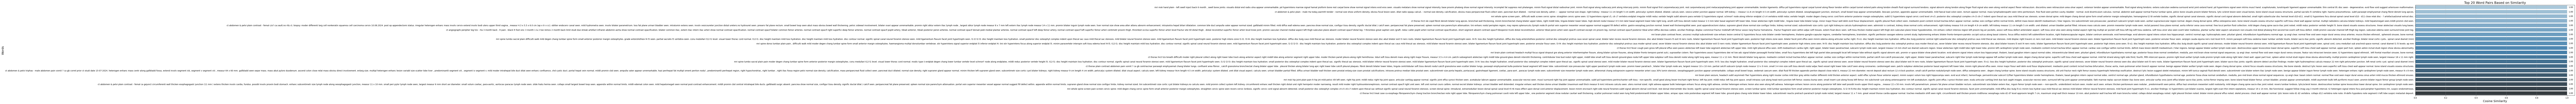

In [23]:
# Prepare data for visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extracting top word pairs and their similarities
top_words = [(data.iloc[pair[0]]['Processed'], data.iloc[pair[1]]['Processed'], pair[2]) for pair in top_100_pairs]
top_words_df = pd.DataFrame(top_words, columns=['Word1', 'Word2', 'Similarity'])

# Prepare the data for the top 20 pairs
top_20_df = top_words_df.head(20)

# Plotting the top word pairs as a horizontal bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Similarity', y='Word1', data=top_20_df, palette='Blues_d')

# Adding title and labels
plt.title('Top 20 Word Pairs Based on Similarity', fontsize=16)
plt.xlabel('Cosine Similarity', fontsize=14)
plt.ylabel('Words', fontsize=14)

# Adding similarity scores as annotations
for index, row in top_20_df.iterrows():
    plt.text(row['Similarity'] + 0.01, index, f'{row["Similarity"]:.2f}', color='black', ha='left', va='center')

plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: Add gridlines for better readability
plt.show()


#### 5.Interactive Visualization

In [25]:
# Create an interactive visualization with Plotly
import plotly.express as px

# Prepare the data for the interactive visualization
top_words_df['Word Pair'] = top_words_df['Word1'] + " & " + top_words_df['Word2']

# Create a scatter plot
fig = px.scatter(
    top_words_df,
    x='Word1',
    y='Word2',
    size='Similarity',
    color='Similarity',
    hover_name='Word Pair',
    hover_data={'Similarity': True},
    title='Word Pairs Similarity',
    labels={'Word1': 'Word 1', 'Word2': 'Word 2', 'Similarity': 'Cosine Similarity'},
    color_continuous_scale=px.colors.sequential.Plasma  # Change the color scale for better aesthetics
)

# Update layout for better readability
fig.update_traces(marker=dict(sizemode='diameter', opacity=0.8, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    title_font=dict(size=20, family='Arial, sans-serif', color='darkblue'),
    xaxis_title='Words',
    yaxis_title='Words',
    xaxis=dict(title_font=dict(size=16), tickfont=dict(size=12)),
    yaxis=dict(title_font=dict(size=16), tickfont=dict(size=12)),
    legend_title_text='Cosine Similarity',
    template='plotly_white'  # Use a clean white background
)

# Show the figure
fig.show()
